# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2023 (c) András Béres
</PRE>

Install necessary packages:
* PyTorch Lightning: high-level deep learning library over PyTorch.
* Weights and Biases: library used for logging metrics and model checkpoints.
* Datasets: library for loading datasets from the Hugging Face Hub (https://huggingface.co/datasets).

In [163]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

Load the necessary libraries.

In [164]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms.v2 import RandomPerspective
from torchvision.transforms.v2 import RandomZoomOut
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets

Login to WandB. Make sure that you have a valid WandB account. Ctrl + click on the link, copy the token from the opened page.

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Hyperparameters

In [165]:
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2 #hány cpu-t használsz alapból -- annyi legyen ahány mag van
num_epochs = 30
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

## Data pipeline

* We will be using the https://huggingface.co/datasets/lewtun/dog_food dataset.
* What is the difference between dataset and dataloader?
* What is the difference between image preprocessing and image augmentations? Look at the transforms. What do we use during training and validation?
* Best practices:
    * Set `num_workers > 0`. A good starting point is the number of CPU cores on your system.
    * If you use a GPU, set `pin_memory = True`. This improves the speed of CPU-to-GPU data transfer.
    * If you want to have a consistent batch_size in all iterations, set `drop_last = True`.
    * During training, set `shuffle = True`, which shuffles the order of frames in the dataset.

In [177]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            #RandomPerspective(),
            transforms.RandomHorizontalFlip(),
            #RandomZoomOut(),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  #--> ezzel is lehet csinálni dolgokat, kikommentezni és jobb lesz
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),

            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,          #Beállítod gyorsabb lesz az adatbetöltés
            drop_last=True,           #Csak train-nél legyen, kidobál képet
            shuffle=True,             #Csak trainnél
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [178]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

In [179]:
train_dataloader = datamodule.train_dataloader()

# Get a batch of data
batch = next(iter(train_dataloader))

# Inspect the size of the tensors in the batch
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"Tensor '{key}' shape: {value.shape}")

Tensor 'image' shape: torch.Size([32, 3, 112, 112])
Tensor 'label' shape: torch.Size([32])


## Visualization
* PyTorch uses channels first representation (batch, channels, height, width) vs channels last (batch, height, width, channels) by default. Keep that in mind during visualization, because matplotlib expects channels last format.

In [122]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


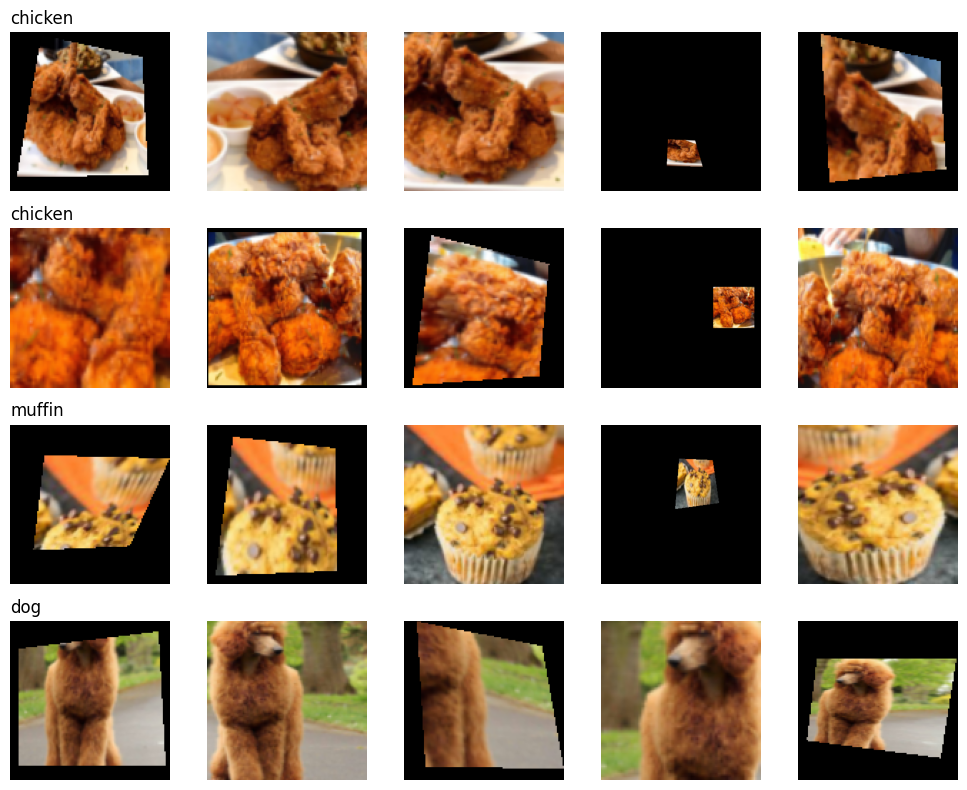

In [123]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

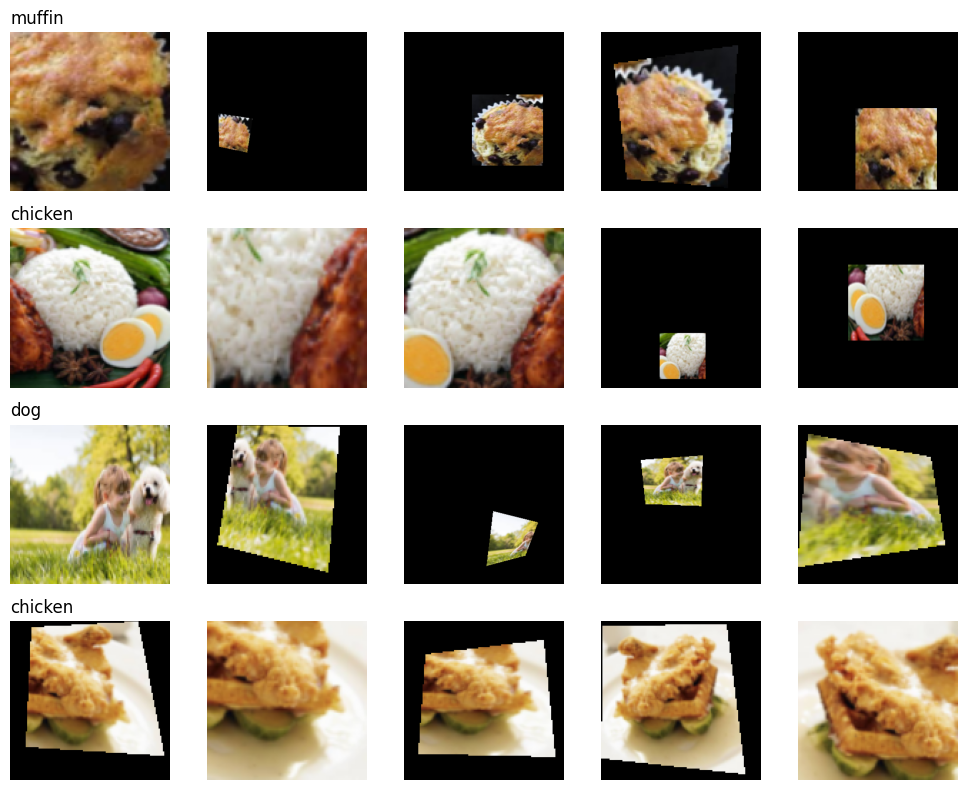

In [124]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

## Classifier Model Definition

In [266]:
import io
import pandas as pd
import seaborn as sns
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes,task="multiclass")
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])
        # Calculate confusion matrix

        confusion_matrix = self.confusion_matrix(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        self.log_confusion_matrix_as_image(confusion_matrix, prog_bar=False)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        #return torch.optim.Adam(self.parameters(), lr=learning_rate)
        return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        #return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay) # csak az utolsó layert tanítjuk, hogy ne felejtse el az előtanított dolgokat



    def log_confusion_matrix_as_image(self, confusion_matrix, prog_bar=True):
        # Convert the confusion matrix to a NumPy array
        confusion_matrix = confusion_matrix.cpu().numpy()

        # Create a heatmap
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")


        # Save the heatmap as an image file
        image_path = "confusion_matrix.png"
        plt.savefig(image_path, format="png")
        plt.close()

        # Log the image file path
        self.log("confusion_matrix", image_path, prog_bar=prog_bar)


## Convolutional Neural Network Definiton

* Observe our custom CNN.
* What do each of the Conv2d parameters mean?
* What are the output shapes of each layer?
* What is a fully convolutional neural network? What is their advantage?

In [181]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)



#model = torchvision.models.mobilenet_v2(num_classes=num_classes)

#model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
#model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True) #kicseréljük az utolsó layert, hogy csak 3 kimenet legyen

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


Best practices:
* Use 16-bit floating point mixed precision for >2x faster training and 2x lower GPU memory consumption.
* If using a PyTorch 2.x on a modern GPU (Volta or Ampere architecture e.g. V100 or A100), compile your neural network.
* For better GPU utilization, use larger batch sizes.

In [267]:
# model = torch.compile(model)  #összeolvaszt dolgokat és elv gyorsabb lesz a tanítás sok gpu-n
lit_model = ImageClassifier(model)

## Training
* We log our metrics using a `WandbLogger`.
* We save our best checkpoints using a `ModelCheckpoint` callback.

In [202]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model,datamodule)
#wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | Sequential         | 113 K 
1 | accuracy | MulticlassAccuracy | 0     
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
# if you stop your training early, run this line manually, to finish the wandb run
# wandb.finish()

# Tasks (during practice)
1. Visualize the augmented/preprocessed training/validation images. What do we see?
2. Turn image augmentations off in the training transforms.
3. Inspect the baseline CNN. What are the output shapes after each layer?
4. Run the baseline training.
5. Remove all ReLUs from our convolutional network. What do we expect? What do we see?
6. Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)?
7. Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).
8. Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.
* **Warning 1**: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
* **Warning 2**: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.
9. Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?

# Tasks (homework)
Kövi előadás elejéig kell leadni
1. Add at least two other image augmentations to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure as "task_1.png". (20 p)
2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? Save it to line 1 of "task_2.txt". What is the exact number of trainable parameters in the new network? Save it to line 2 of "task_2.txt". (20 p)
3. Load your best model from WandB. Run an evaluation. What is the validation loss? Save it to line 1 of "task_3.txt". What is the validation accuracy? Save it to line 2 of "task_3.txt". (25 p)
4. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run another evaluation, and visualize the confusion matrix. Save the generated figure as "task_4.png". (25 p)
5. Upload your final jupyter notebook containing all the solutions as "task_5.ipynb". (10 p)

## Get tests

In [31]:
# run only once

!wget https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_1
!wget https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_2
!wget https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_3
!wget https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_4
!wget https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_5

!chmod u+x test_1
!chmod u+x test_2
!chmod u+x test_3
!chmod u+x test_4
!chmod u+x test_5

--2023-11-02 20:39:54--  https://github.com/BME-SmartLab-VITMMA19/vision-assignment/raw/main/test_1
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BME-SmartLab-VITMMA19/vision-assignment/main/test_1 [following]
--2023-11-02 20:39:54--  https://raw.githubusercontent.com/BME-SmartLab-VITMMA19/vision-assignment/main/test_1
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6028488 (5.7M) [application/octet-stream]
Saving to: ‘test_1’

test_1              100%[===================>]   5.75M  --.-KB/s    in 0.08s   

2023-11-02 20:39:54 (67.9 MB/s) - ‘test_1’ saved [6028488/6028488]

--2023-11-02 20:39:

## Run tests

In [ ]:
!./test_1
!./test_2
!./test_3
!./test_4
!./test_5

Add at least two other image augmentations to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure as "task_1.png". (20 p)

In [133]:
def visualize_images_task1(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig('task_1.png')



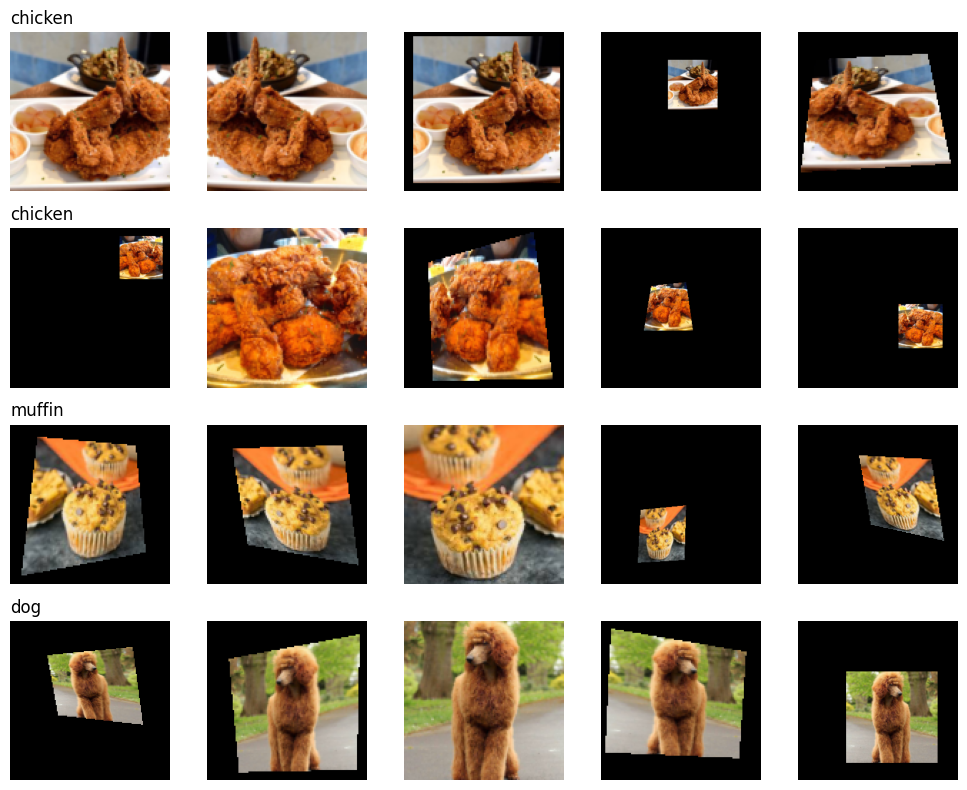

<Figure size 640x480 with 0 Axes>

In [134]:
visualize_images_task1(datamodule.train_dataset, num_images=4, num_augmentations=5)

Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? Save it to line 1 of "task_2.txt". What is the exact number of trainable parameters in the new network? Save it to line 2 of "task_2.txt". (20 p)

In [188]:
total_params_new = sum(
	param.numel() for param in model.parameters()
)


In [189]:
total_params_new

113283

In [184]:
model_old = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

In [185]:
total_params_old = sum(
	param.numel() for param in model_old.parameters()
)

In [186]:
total_params_old

112771

In [190]:
f = open("task_2.txt", "w")
f.write(str(total_params_old)+'\n')
f.write(str(total_params_new))
f.close()

Load your best model from WandB. Run an evaluation. What is the validation loss? Save it to line 1 of "task_3.txt". What is the validation accuracy? Save it to line 2 of "task_3.txt". (25 p)

In [203]:
trainer.validate(lit_model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9666666388511658     │
│         val_loss          │    0.17132413387298584    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.17132413387298584, 'val_acc': 0.9666666388511658}]

In [205]:
# Access the validation logs
validation_logs = trainer.callback_metrics

In [206]:
validation_logs

{'val_loss': tensor(0.1713), 'val_acc': tensor(0.9667)}

In [214]:

val_loss = validation_logs["val_loss"].item()
val_acc = validation_logs["val_acc"].item()

In [215]:
val_loss

0.17132413387298584

<built-in method keys of dict object at 0x7b5dd6703c80>


In [218]:
with open("task_3.txt", "w") as f:
    f.write(f"{val_loss:.4f}\n")
    f.write(f"{val_acc:.4f}")

Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run another evaluation, and visualize the confusion matrix. Save the generated figure as "task_4.png". (25 p)

In [268]:
trainer.validate(lit_model,datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
validation_logs = trainer.callback_metrics

In [ ]:
import seaborn as sns
# Access the confusion matrix tensor
confusion_matrix_tensor = trainer.callback_metrics["confusion_matrix"]

# Convert the tensor to a NumPy array
confusion_matrix = confusion_matrix_tensor.cpu().numpy()

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Upload your final jupyter notebook containing all the solutions as "task_5.ipynb". (10 p)